In [248]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
from kinetics import rHDS, rHDN_NB, rHDN_B, rHDA

## Olhar Mederos 2006

In [249]:
#[0] = S

#[1] = NNB

#[2] = NB

#[3] = A

#[4] = H2

#[5] = H2S

#[6] = Np


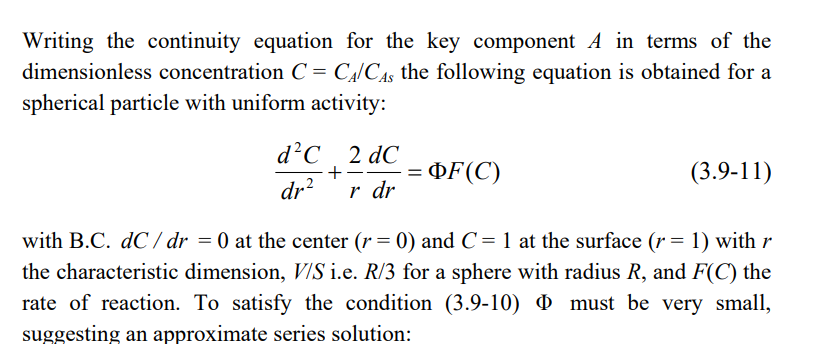

In [250]:
T = 380+273.15  #Temperature in K

P = 5.3e6 #Pressure in Pa

API = 22

Mm1 = 441.9 #molecuar weigth of the oil.

rhob = 0.8163 #bulk density in g/cm^3

uG = 0.28 #superficial gas velocity in cm/s

uL = 1.75e-2 #superficial liquid velocity in cm/s.

T_MeABP = (476 + 273.15)*1.8 # Mean average boiling point of oil in °R.

dp = 0.254 #equivalent diameter in cm

Vn = 8.3145*273.15/101325*1000 #Volume molar at standard conditions in Nl.

alfa1 = 7 #first coeficient of gas-liquid mass transfer in cm^(-1.6).

alfa2 = 0.4 #second coeficient of gas-liquid mass transfer

def specific_gravity(API):

    '''Get the specific gravity of oil.
    Parameters
    ----------
    API: int or float

    Returns
    -------
    The specific_gravity of oil.
    specific_gravity: float

    '''
    return 141.5/(API + 131.5)

roW = 999.007 #density of water at 15.6°C in kg/m^3.

d15_6 = specific_gravity(API)

rho0 = d15_6*roW #Specific gravity of oil.

vc1_m = 7.5214e-3*T_MeABP**0.2896*d15_6**(-0.7666) #critical specific volume in ft^3/lb.

vc_2 = 65.1 #critical specific volume of hydrogen in cm^3/mol.

vc_4 = 98.6 #critical specific volume of hydrogen sulfite in cm^3/mol.

vc1 = vc1_m*Mm1*62.42691047619048 #critical specific volume of the oil in cm^3/mol.

v1 = 0.285*vc1**1.048 #volume molar of the oil in cm^3/mol.

v2 = 0.285*vc_2**1.048   #volume molar of hydrogen in cm^3/mol.

v4 = 0.285*vc_4**1.048   #volume molar of hydrogen sulfite in cm^3/mol.

z = 31.54 #length of the reactor

LHSV = 2 # Liquid Hourly Space Velocity in h-1.

diameter_reactor = 2.54 #diameter of the reactor in cm

In [251]:
Ac = np.pi*diameter_reactor**2/4

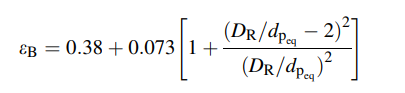

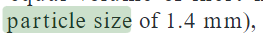

In [252]:
def get_bed_fraction(DR, dp):

    return 0.38 + 0.073*(1 + (DR/dp - 2)**2/(DR/dp)**2)

In [253]:
porosity = get_bed_fraction(2.54, 0.254)

In [254]:
def deltarhoP(rho0,P):

    '''Function to get the density of oil corretion with pressure.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in lb/ft^3.
        
        P: int or float
           Pressure in psia.

        Returns
        -------
        deltarhoP: float
                  Density correction with pressure in lb/ft^3.

    '''

    return ((0.167 + (16.181*10**(-0.0425*rho0)))*(P/1000) - 0.01*(0.299 + (263*10**(-0.0603*rho0)))*(P/1000)**2)

def deltarhoT(rho0, P, T):

    '''Function to get the density of oil corretion with temperature.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in lb/ft^3.
        
        P: int or float
           Pressure in psia.
    
        T: int or float
           Temperature in  °R.

        Returns
        -------
        deltarhoT: float
                  Density correction with temperature in lb/ft^3.

    '''

    return ((0.0133 + 152.4*(rho0 + deltarhoP(rho0,P))**(-2.45)))*(T-520) - (8.1*10**(-6) - 0.0622*10**((-0.764)*(rho0 + deltarhoP(rho0,P))))*(T-520)**2


def oil_density(rho0,P,T):

    '''Get the density of oil in function of pressure and temperature.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        oil_density: float
                  Density correction with temperature and pressure in g/cm^3.

    '''    

    rho0 = rho0/16.018
    T = 1.8*T
    P = P*14.7/101325

    return (rho0 + deltarhoP(rho0,P) - deltarhoT(rho0,P,T))*0.016018

In [255]:
V_reactor = Ac*z  #Volume of the reactor
fi = 356 #H2/ Oil Ratio std m3/m3

In [256]:
uL = LHSV/3600*V_reactor/Ac
uG = uL*(1e5/P)*(T/273.15)*fi

In [257]:
GL = uL*oil_density(rho0,P,T)

In [258]:
def mi_L(T,API=API):

      '''Function to get the viscosity of oil.

      Parameters
      ----------
      API: float or int
            API gravity of oil.   

      T: int or float
            Temperature in K.

      Returns
      -------
      mi_L: float
            Viscosity of oil sulfite in g/(cm*s).'''

      T = T*1.8

      a = 10.313*np.log10(T - 460) - 36.447
      return 3.141e10*(T - 460)**(-3.444)*((np.log10(API))**a)/100


def D1L(T = T):

      '''Gets the coefficient of diffusivity of the organic sulfur compound in solution in cm^2/s.

      Parameters
      ----------
      T: int or float
            Temperature in K.

      Returns
      -------
      D1L: float
            The difusivity coefficient.
      '''

      return (8.93e-8*(v1**0.267)*T)/((v1**0.433)*(mi_L(T)*100))

def D2L(T = T):

      '''Gets the coefficient of diffusivity of hydrogen in solution in cm^2/s.

      Parameters
      ----------
      T: int or float
            Temperature in K.

      Returns
      -------
      D2L: float
            The difusivity coefficient.
      '''

      return (8.93e-8*(v1**0.267)*T)/((v2**0.433)*(mi_L(T)*100))

def D4L(T = T):

      '''Gets the coefficient of diffusivity of hydrogen sulfite in solution in cm^2/s.

      Parameters
      ----------
      T: int or float
            Temperature in K.

      Returns
      -------
      D2L: float
            The difusivity coefficient.
    '''

      return 8.93e-8*v1**0.267*T/v4**0.433/(mi_L(T)*100)

In [259]:
def Lambda2(T):

    '''Function to get the solubility of hydrogen in hydrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in K.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen in (Nl H2,)/[(g oil)*(MPa)].
    '''
    T = T - 273.15

    ro_20 = oil_density(rho0,101325,293.15)

    return  (-0.559729 - 0.42947e-3*T + 3.07539e-3*T/ro_20 + 1.94593e-6*T**2 + 0.835783/ro_20**2) 

def Henry_coefficient2_fun(rho0 = rho0, P = P, T = T):

    '''Function to get the Henry coefficient of hydrogen in hydrocarbon mixtures.
     
        rho0: int or float
            Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        H: float
           The Henry coefficient for hydrogen in MPa.cm^3/mol. '''  

    
    return Vn/(Lambda2(T)*oil_density(rho0,P,T)/1000)

def Lambda4(T=T):

   '''Function to get the solubility of hydrogen sulfite in hidrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in °C.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen sulfite in (Nl H2S,)/[(g oil)*(MPa)].
    '''
   T = T - 273.15

   return np.exp(3.3670 - 0.008470*T)

def Henry_coefficient4_fun(rho0 = rho0, P = P, T = T):

    '''Function to get the Henry coefficient of hydrogen sulfite in hydrocarbon mixtures. 

        Parameters
        ----------

        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        H: float
           The Henry coefficient for hydrogen sulfite in MPa.cm^3/mol. '''  

    return Vn/(Lambda4(T)*oil_density(rho0,P,T)/1000)



In [260]:
def k2L_aL_fun(rho0 = rho0, P = P, T = T): 
    
   '''Get the gas-liquid mass transfer coefficient from liquid to particle for hydrogen.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k2Lat: float
             Mass transfer coefficient in s^-1.'''
   
     
   return D2L(T)*alfa1*(GL/mi_L(T))**alfa2*(mi_L(T)/(oil_density(rho0,P,T)*D2L(T)))**(0.5)

def k4L_aL_fun(rho0 = rho0, P = P, T = T): 
    
   '''Get the gas-liquid mass transfer coefficient from liquid to particle for hydrogen sulfite.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k4Lat: float
             Mass transfer coefficient in s^-1.'''
   
     
   return D4L(T)*alfa1*(GL/mi_L(T))**alfa2*(mi_L(T)/(oil_density(rho0,P,T)*D4L(T)))**(0.5)

def aS_fun(dp=dp,porosity = 0.5):

    '''Gets the specific surface area of the packing.

        Parameters
        ----------
        dp: int or float
            Diameter of the pellet in cm.

        porosity: int or float
                  The void fraction of the catalystic bed.

        Return
        ------
        a_super: float
                 The specific surface area of the packing in cm^-1.
    '''

    return 6*(1-porosity)/dp

def k1S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for organic sulfur compound.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k1S: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D1L(T)*aS_fun()*1.8*(GL/(mi_L(T)*aS_fun()))**0.5*(mi_L(T)/(oil_density(rho0,P,T)*D1L(T)))**(1/3)

def k2S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for hydrogen.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k2S: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D2L(T)*aS_fun()*1.8*(GL/(mi_L(T)*aS_fun()))**0.5*(mi_L(T)/(oil_density(rho0,P,T)*D2L(T)))**(1/3)

def k4S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for hydrogen sulfite.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k4sat: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D4L(T) * aS_fun()*1.8 * (GL/(mi_L(T)*aS_fun()))**0.5 * (mi_L(T)/(oil_density(rho0,P,T)*D4L(T)))**(1/3)

In [261]:
def k(k0, Ea, T, R=8.3145):
    """Calculate the cinetic constant of Arrhneius.

    Args:
        k0 (float): the pre-exponencial factor.
        Ea (float): activation energy in [kJ/mol].
        T(float): Temperature in [K].
        R (float): The gas constant in [J/(mol.K)].

    Returns:
        float: The constant cinetic.
    """
    return k0 * np.exp(-Ea*1e3 / (R * T))


def fKH2S(T, k0=41769.8411, delta_Hads=2761, R=8.3145):
    """Calculate the equilibrium constant of hydrodessulfulrization.

    Args:
        T(float): Temperature in [K].
        k0 (float): the pre-exponencial factor.
        delta_Hads (float): delta energy of adsorption in [J/mol].
        R (float): The gas constant in [J/(mol.K)].

    Returns:
        float: The equilibrium constant in [cm^3/mol].

    """
    return k0 * np.exp(delta_Hads / (R * T))


def rHDS(CS, CH2, CH2S, T):
    """ Calculate the HDS reaction rate.
    Args:
        CS (float): Concentration OF sulfur compounds in [mol/cm^3].
        CH2 (float): Concentration of hydrogen in [mol/cm^3].
        CH2S (float): Concentration of hydrogen sulfide in [mol/cm^3].
        T (float): Temperature in [K].

    Returns:
        float: The HDS reaction rate in [mol/s].
    """

    return k(4.266e9, 131.99, T) * CS * CH2**0.45/(1 + fKH2S(T) * CH2S)**2


def rHDN_B(CN_NB, CN_B, T):
    """ Calculate the HDN_B reaction rate.
    Args:
        CN_NB (float): Concentration of non-basic-nitrogen compounds in [wt%].
        CN_B (float): Concentration of basic-nitrogen in [wt%].
        T (float): Temperature in [K].

    Returns:
        float: the HDN_NB reaction rate in [wt%/s].
    """

    return  k(3.62e6, 164.94, T) * CN_NB**1.5 - k(3.66e11, 204.34, T) * CN_B**1.5


def rHDN_NB(CN_NB, T):
    """ Calculate the HDN_NB reaction rate.
    Args:
        CN_NB (float): Concentration of non-basic-nitrogen compounds in [wt%].
        T (float): Temperature in [K].

    Returns:
        float: the HDN_B reaction rate in [wt%/s].
    """

    return k(3.62e6, 164.94, T) * CN_NB**1.5


In [262]:
H2 = Henry_coefficient2_fun()

H4 = Henry_coefficient4_fun()

In [263]:
w0 = 0.02009 #weigth fraction of sulfur.
w1 = (1284 - 518)*1e-6 #weigth fraction of non basic nitrogen.
w2 = 518*1e-6 #weigth fraction of basic nitrogen.
w3= 0.419 #weigth fraction of aromatic compounds.


rhoL = oil_density(rho0,P,T)

In [264]:
 ## INITIAL  CONCENTRATIONS

cL00 = rhoL*w0/Mm1
cL10 = rhoL*w1/Mm1
cL20 = rhoL*w2/Mm1
cL30 = rhoL*w3/Mm1


In [265]:
pG40 = 5.3
pG50 = 0
cL40 = pG40/H2 #inlet concentration of hydrogen in mol/cm^3 .
cL50 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .
cL60 = 0 #inlet concentration of naphtneses in mol/cm^3 .
z0=0
z=31.54 #length of reactor

## The mass-balance equation for components in the gas phase in the reactor

![Alt text](image-5.png)

Me basear nesse artigo e corrigir as quantidades finais dos compostos aromáticos gerados, não básicos e básicos

In [266]:
k2L_aL = k2L_aL_fun()


k4L_aL = k4L_aL_fun()


k1S_aS = k1S_fun()*aS_fun()


k2S_aS = k2S_fun()*aS_fun()


k4S_aS = k4S_fun()*aS_fun()

In [267]:
def mass_balance_gas_phase2(p2G, C2L, uG = uG, R=8.3145, T = T):

    return - k2L_aL * (p2G / H2 - C2L) * R * T / uG 

def mass_balance_gas_phase4(p4G, C4L, uG = uG, R=8.3145, T = T):

    return - k4L_aL * (p4G / H4- C4L) * R * T / uG

def mass_balance_gas_liquid_phase2(p2G, C2L, C2S, uL = uL):

    return (k2L_aL * (p2G / H2 - C2L) -  k2S_aS * (C2L - C2S)) / uL

def mass_balance_gas_liquid_phase4(p4G, C4L, C4S, uL = uL):
    
    return (k4L_aL * (p4G / H4 - C4L) -  k4S_aS * (C4L - C4S)) / uL

def mass_balance_liquid(C1L, C1S, uL = uL):  #C1L = S, NB, NNB or A

    return - (C1L - C1S) * k1S_aS / uL

In [268]:
def constraints(C,variables):

    ni0 = -1
    ni1 = -1
    ni2 = 1
    ni3 = -1
    ni4 = -15
    ni5 = 9
    ni6 = 1

    eff= 1

    cS0 = C[0]
    cS1 = C[1]
    cS2 = C[2]
    cS3 = C[3]
    cS4 = C[4]
    cS5 = C[5]
    cS6 = C[6]

    
    F = np.empty((7))
    F[0] =  - ni0*eff*rhob * rHDS(cS0, cS4, cS5,T)  -  k1S_aS*(variables[0] - cS0)
    F[1] =  - ni1*eff*rhob * rHDN_NB(cS1*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[1] - cS1)
    F[2] =  - ni2*eff*rhob * rHDN_B(cS1*Mm1/rhoL*100, cS2*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[2] - cS2)
    F[3] =  - ni3*eff*rhob * rHDA(variables[7], cS3, cS6, T) -  k1S_aS * (variables[3] - cS3)
    F[4] =  - ni4*rhob *eff*rHDS(cS0, cS4, cS5,T)   - k2S_aS * (variables[4] - cS4)
    F[5] =  - ni5*rhob *eff*rHDS(cS0, cS4, cS5,T)   - k4S_aS * (variables[5] - cS5)
    F[6] =  - ni6*eff*rhob * rHDA(variables[7], cS3, cS6, T) -  k1S_aS * (variables[6] - cS6)

    return F

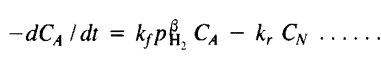

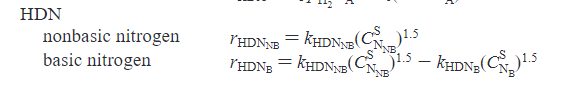

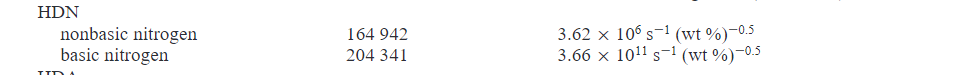

Depois testar também balanço para o naftaleno

## Resolver daqui para baixo outro dia

In [269]:
def dy(z, variables):

    cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG4, pG5 = variables
    
    if z==z0:
        solid_concentrations = root(constraints, [cL00, cL10, cL20, cL30, cL40, cL50, cL60], [cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG40], method = "lm").x

    else:
        solid_concentrations = root(constraints, [cL0,  cL1, cL2, cL3, cL4, cL5, cL6], [cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG4], method = "lm").x



    return np.array([mass_balance_liquid(cL0, solid_concentrations[0]),
     mass_balance_liquid(cL1, solid_concentrations[1]),
     mass_balance_liquid(cL2, solid_concentrations[2]),
     mass_balance_liquid(cL3, solid_concentrations[3]),     
     mass_balance_gas_liquid_phase2(pG4, cL4, solid_concentrations[4]),
     mass_balance_gas_liquid_phase4(pG5, cL5, solid_concentrations[5]),
     mass_balance_liquid(cL6, solid_concentrations[6]),
     mass_balance_gas_phase2(pG4, cL4),
     mass_balance_gas_phase4(pG5, cL5)])

In [270]:
t_span = [z0, z]
t_eval = np.linspace(0, z, 1000)
y0 = [cL00, cL10, cL20, cL30, cL40, cL50, cL60, pG40, pG50]

In [271]:
sol = solve_ivp(dy, t_span=t_span, y0=y0, t_eval=t_eval, method = "RK45")

![Alt text](image-3.png)

![Alt text](image-4.png)

In [272]:
cL0_fun,  cL1_fun, cL2_fun, cL3_fun, cL4_fun, cL5_fun, cL6_fun, p4G_fun, p5G_fun = sol.y

In [273]:
import matplotlib.pyplot as plt

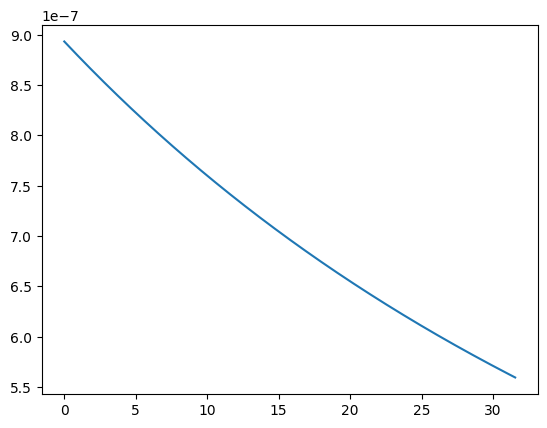

In [274]:
z_lin = np.linspace(0,z,1000)
plt.plot(z_lin,cL2_fun)

In [275]:
p4G_fun

array([5.3       , 5.29999665, 5.29998683, 5.29997091, 5.29994926,
       5.29992221, 5.29989001, 5.29985287, 5.29981102, 5.29976468,
       5.29971404, 5.29965933, 5.29960071, 5.29953839, 5.29947254,
       5.29940333, 5.29933094, 5.29925551, 5.2991772 , 5.29909615,
       5.2990125 , 5.29892639, 5.29883792, 5.29874722, 5.29865437,
       5.29855943, 5.29846247, 5.29836358, 5.29826281, 5.29816025,
       5.29805596, 5.29795   , 5.29784245, 5.29773337, 5.29762281,
       5.29751085, 5.29739754, 5.29728293, 5.2971671 , 5.29705008,
       5.29693194, 5.29681273, 5.29669249, 5.29657128, 5.29644915,
       5.29632614, 5.29620229, 5.29607766, 5.29595228, 5.2958262 ,
       5.29569944, 5.29557202, 5.29544396, 5.29531527, 5.29518598,
       5.29505609, 5.29492563, 5.29479462, 5.29466307, 5.294531  ,
       5.29439843, 5.29426538, 5.29413186, 5.2939979 , 5.29386351,
       5.29372871, 5.29359351, 5.29345795, 5.29332202, 5.29318576,
       5.29304917, 5.29291229, 5.29277512, 5.29263768, 5.29249

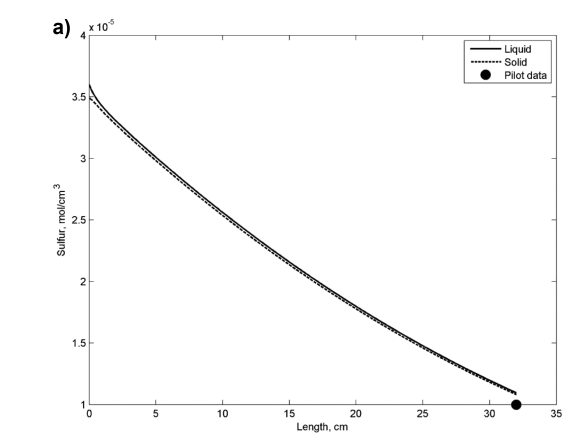

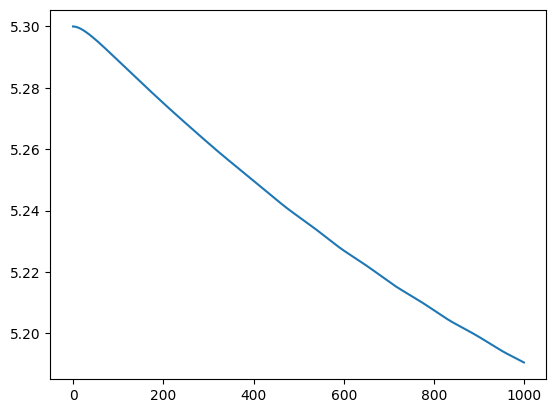

In [276]:
plt.plot(p4G_fun)
plt.show()

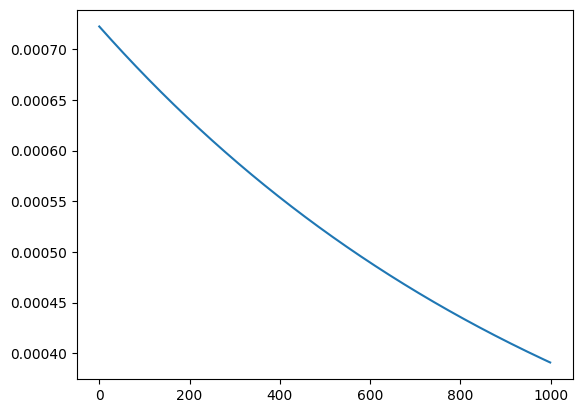

In [277]:
plt.plot(cL3_fun)
plt.show()


## Cálculo da efetividade

In [278]:
from scipy.integrate import solve_bvp
from scipy.integrate import romberg, quad

Estudar conteúdo desse link: https://stackoverflow.com/questions/60293084/scipy-solve-bvp-problem-2nd-order-diff-eq

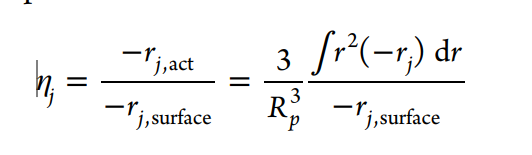